1. Get embeddings (resnet50)
2. knn ranking    (sklearn.neighbors.NearestNeighbors)


1. get embeddings   (resnet50)
2. classifier       (KNN)
3. knn within class (sklearn.neighbors.NearestNeighbors)


1. get embeddings           (resnet50)
2. Dimensionality reduction (PCA)
3. classifier               (KNN)
4. knn within class         (sklearn.neighbors.NearestNeighbors)


1. get embeddings           (AutoEncoder)
2. Dimensionality reduction (PCA)
3. classifier               (TripletLoss)
4. knn within class         (sklearn.neighbors.NearestNeighbors)


In [12]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

In [13]:
from utils import plot_confusion_matrix

In [14]:
# !python3 -m pip install seaborn
import seaborn as sn

In [2]:
image_folder = '/mnt/osn3/caceres/classes/geological/geological_similarity'

In [3]:
classes = [ 'andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

# Method 1: 
1. Get embeddings
2. knn ranking

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import transforms

In [5]:
resnet50 = models.resnet50(pretrained=False)

In [6]:
resnet50.load_state_dict(torch.load('/home/ccaceresgarcia/Documents/Projects/image_search/resnet50-19c8e357.pth')) # path of your weights

<All keys matched successfully>

In [36]:
_ = resnet50.eval()
_ = resnet50.cuda()

In [8]:
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

resnet50 = resnet50.to(device)


In [15]:

labels = []
filenames = []
features = []
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')

    for filename in image_list:

        image = Image.open(filename) # read image
        im = np.asarray(image)# convert image to numpy array
        img = transform(im) # convert to tensor
        #img = img.reshape(1,3,28,28)
        img = torch.unsqueeze(img, 0)
        img = img.to(device)

        with torch.no_grad():
            feature = resnet50(img)
        
        features.append(feature.cpu().detach().numpy().reshape(-1))
        labels.append(label)
        filenames.append(filename)
        
features2 = np.array(features)
print(features2.shape)

/home/ccaceresgarcia/miniconda3/envs/spot4/lib/python3.6/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629416375/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


(29998, 2048)


## Write vectors to file for s3 upload

In [94]:
f3 = [str(list(x)) for x in features]

In [93]:
import csv

with open("resnet_vectors.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(f3)

In [105]:
label_features = {}
for i, label in enumerate(classes):
    label_features[i] = [(x, name) for name,x, la in zip(filenames, f3, labels) if la == label]

In [106]:
[len(x) for i, x in label_features.items()]

[5000, 5000, 4998, 5000, 5000, 5000]

### Per Class files

In [114]:
for i, label in enumerate(classes):
    f4, lab_names = zip(*label_features[i])
    
    feature_data = {'labels':label, 
                'filenames':lab_names,
                'features':f4}
    
    with open('resnet_vectors_{}.json'.format(label), 'w') as f:
        json.dump(feature_data, f)

In [96]:
feature_data = {'labels':labels, 
                'filenames':filenames,
                'features':f3}



In [97]:
import json
with open('resnet_vectors.json', 'w') as f:
    json.dump(feature_data, f)

## Make KNN object

In [16]:
# for i, label in enumerate(classes):
#     image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
#     print(i,label, len(image_list))
    
# len(labels), len(filenames), len(features)

In [17]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=30, algorithm='brute',metric='euclidean').fit(features)

In [21]:
import pickle 

# Its important to use binary mode 
knnPickle = open('knnpickle_file', 'wb') 

# source, destination 
pickle.dump(neighbors, knnPickle)                      

# load the model from disk
loaded_model = pickle.load(open('knnpickle_file.pickle', 'rb'))


In [23]:
with open('filenames.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(filenames, f, pickle.HIGHEST_PROTOCOL)

with open('filenames.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    loaded_filenames = pickle.load(f)

In [ ]:
# boto3
# !pip3 install requests_aws4auth
# !pip3 install elasticsearch=='7.13.4' #https://opensearch.org/docs/clients/index/


In [27]:
from io import BytesIO
import base64

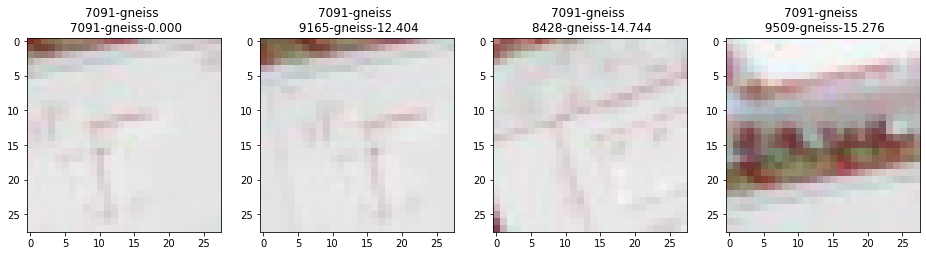

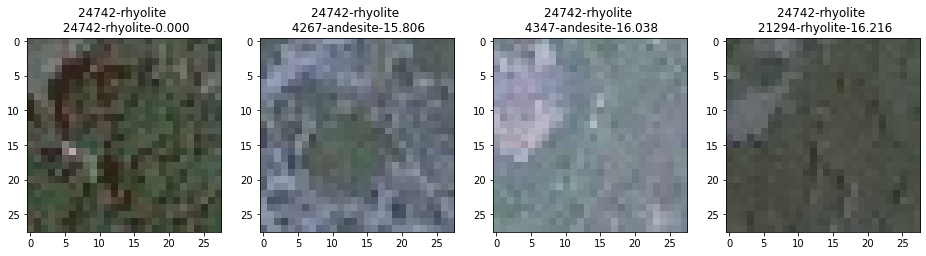

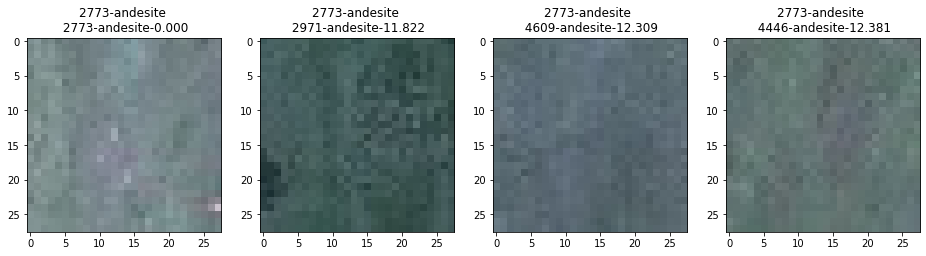

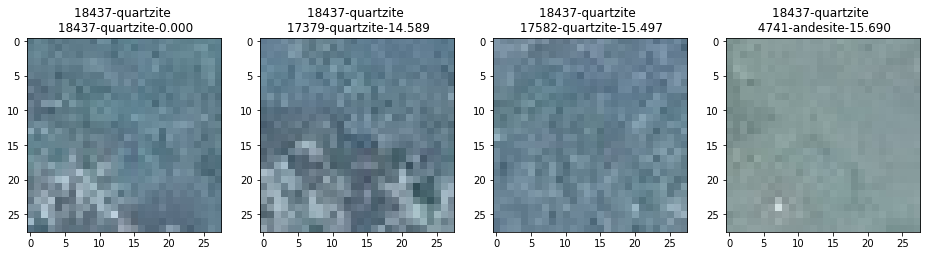

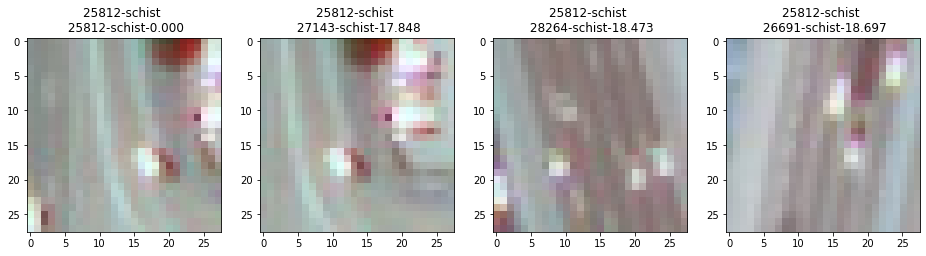

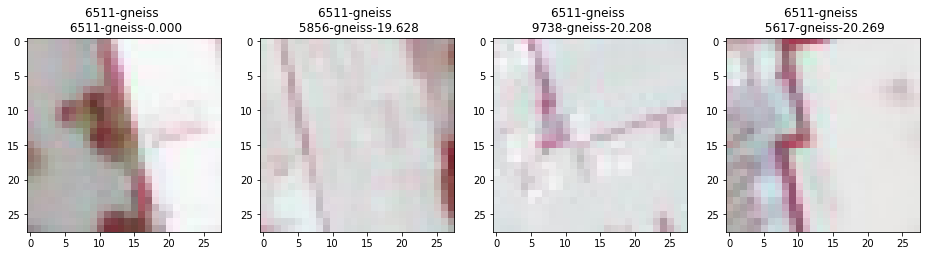

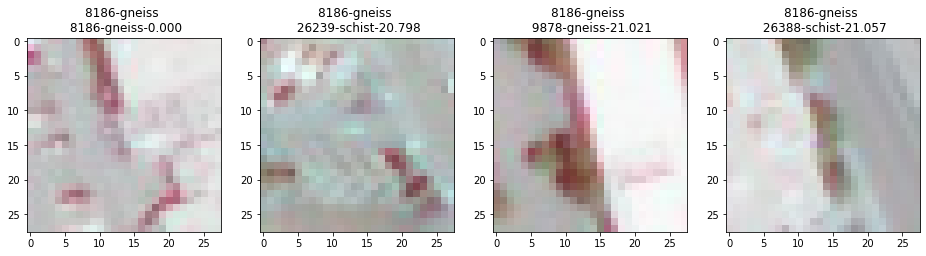

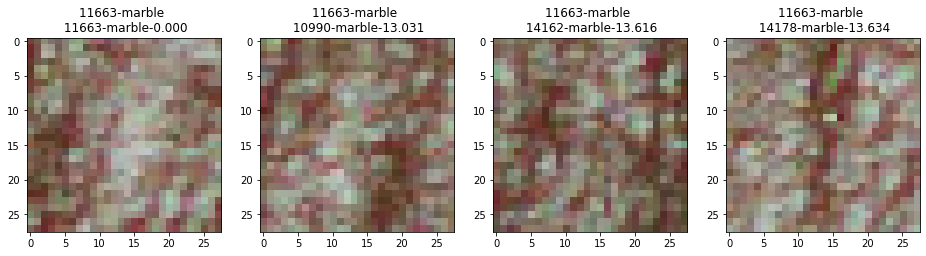

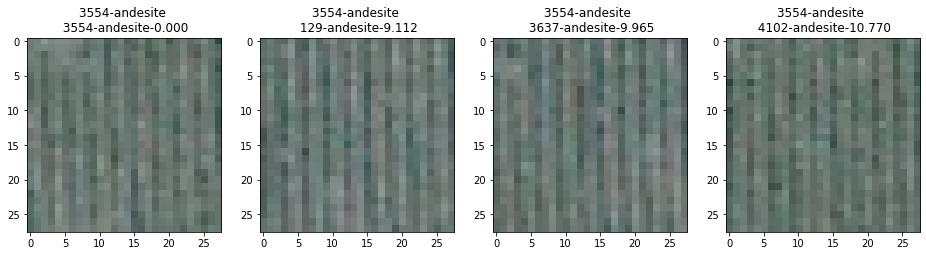

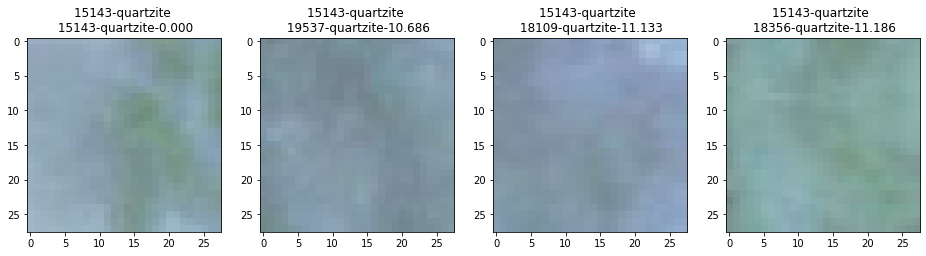

In [25]:
k = 4

for query in [random.randint(0,len(filenames)-1) for _ in range(10)]:
    
    
    image = Image.open(loaded_filenames[query]) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)
    distances, indices = loaded_model.kneighbors([flat_feature])
    
    #distances, indices = neighbors.kneighbors([features2[query]])

    _, axes = plt.subplots(1,k,figsize=(16,4))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(loaded_filenames[match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i].imshow(im)
        axes.flat[i].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              labels[query], 
                                                              match, 
                                                              labels[match], 
                                                              round(distances[0][i],3)))


# Method 2:
1. get embeddings
2. classifier
3. knn within class

# Method 3:
1. get embeddings
2. dimensionality reduction
3. classifier
4. knn within class


In [ ]:
use_pca = False

## Get feature vectors

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import transforms

In [ ]:
resnet50 = models.resnet50(pretrained=False)

In [ ]:
resnet50.load_state_dict(torch.load('/home/ccaceresgarcia/Documents/Projects/image_search/resnet50-19c8e357.pth')) # path of your weights

In [ ]:
resnet50.eval()
resnet50.cuda()

In [ ]:
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [ ]:

labels = []
filenames = []
features = {}
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
    features[i] = []
    
    for filename in image_list:

        image = Image.open(filename) # read image
        im = np.asarray(image)# convert image to numpy array
        img = transform(im) # convert to tensor
        #img = img.reshape(1,3,28,28)
        img = torch.unsqueeze(img, 0)
        img = img.to(device)

        with torch.no_grad():
            feature = resnet50(img)
        
        flat_feature = feature.cpu().detach().numpy().reshape(-1)
        
        features[i].append((flat_feature, label, filename))

## Split into train/test

In [ ]:
for k,v in features.items():
    print(k, len(v))

In [ ]:
test_perc = 0.2

train_set = []
test_set = []
for k,v in features.items():
    random.shuffle(v)
    test_count = int(test_perc * len(v))
    test_set.extend(v[:test_count])
    train_set.extend(v[test_count:])

In [ ]:
train_features, train_labels, train_filenames = list(zip(*train_set))
test_features, test_labels, test_filenames = list(zip(*test_set))

In [ ]:
train_features = np.array(train_features)
test_features = np.array(test_features)

train_features.shape, test_features.shape

## PCA

In [ ]:
if use_pca:
    import numpy as np
    from sklearn.decomposition import PCA

    pca = PCA(n_components='mle')
    pca.fit(train_features) # n_samples, n_features

    print(pca.explained_variance_ratio_),print(pca.singular_values_)

    print(pca.singular_values_.shape)

    train_features = pca.transform(train_features)
    test_features = pca.transform(test_features)


## Train multiclass classifier

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_features)

# train_features = scaler.transform(train_features)
# test_features = scaler.transform(test_features)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features, train_labels)

In [ ]:
y_pred = classifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, y_pred))

In [ ]:
plot_confusion_matrix(confusion_matrix(test_labels, y_pred), classes)

## Make nearest neighbors for each cluster

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 5
class_filenames = {}
class_labels = {}
neighbors = {}
for i, label in enumerate(classes):
    label_features = train_features[[x == label for x in train_labels]]
    
    neighbors[i] = NearestNeighbors(n_neighbors=k, algorithm='brute',metric='euclidean').fit(label_features)

    class_filenames[i] = list(np.array(train_filenames)[[x == label for x in train_labels]])
    class_labels[i] = list(np.array(train_labels)[[x == label for x in train_labels]])
    

# Query

In [ ]:

for query in [random.randint(0,len(test_filenames)-1) for _ in range(10)]:
    
    # get embedding
    image = Image.open(test_filenames[query]) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)

    if use_pca:
        flat_feature = pca.transform([flat_feature])[0]

    # classify    
    y_pred = classifier.predict([flat_feature])
    
    best_class = [i for i,x in enumerate(classes) if x==y_pred[0]][0]
    print(query, test_labels[query], test_filenames[query], ' -- ', best_class, classes[best_class])
    
    # Do KNN ranking
    distances, indices = neighbors[best_class].kneighbors([test_features[query]])

    # display results
    _, axes = plt.subplots(1,k,figsize=(16,4))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(class_filenames[best_class][match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i].imshow(im)
        axes.flat[i].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              test_labels[query], 
                                                              match, 
                                                              class_labels[best_class][match], 
                                                              distances[0][i]))


# Train Triplet Loss Classification Model